In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'transition': 'convex',
              'start_slideshow_at': 'selected'
})

{'start_slideshow_at': 'selected', 'theme': 'simple', 'transition': 'convex'}

In [3]:
# Prepare my slides
%pylab inline
%cd working

Populating the interactive namespace from numpy and matplotlib
/Users/barronh/Development/GCandPython/working


`%matplotlib` prevents importing * from pylab and numpy


# ICARTT Evaluation

Author: Barron H. Henderson

This presentation will teach basics of spatial interpolation and statistical evaluation using Python with PseudoNetCDF, numpy, and scipy.

# Evaluation

1. Step one pairing data
2. Homogonize dimensions
3. Use test metrics

# Pairing Data - Better Interpolation

- In PNC_02Figures , we masked data instead of matching data.
- Ideally, we would have a multi-dimensional interpolation.
- For this we will use scipy KDTree

# First, load the data again

In [4]:
from PseudoNetCDF import PNC

# Read Model Data

In [5]:
margs = PNC('--format=bpch,nogroup=("IJ-AVG-$","PEDGE-$"),vertgrid="GEOS-5-NATIVE"', "bpch/ctm.bpch.v10-01-public-Run0.2013050100")
mfile = margs.ifile[0]
mlon = mfile.variables['longitude']
mlat = mfile.variables['latitude']
MLON, MLAT = np.meshgrid(mlon, mlat)
mO3 = mfile.variables['O3']

# Read Observations

In [6]:
oargs = PNC("-f", "ffi1001", "--rename=v,O3_ESRL,O3", "--variables=Fractional_Day,O3_ESRL,LATITUDE,LONGITUDE,PRESSURE", "--expr=latitude=LATITUDE;longitude=np.where(LONGITUDE>180,LONGITUDE-360,LONGITUDE);time=Fractional_Day*24*3600;time.units=\"seconds since 2011-12-31\"", "icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict")
ofile = oargs.ifile[0]
olons = ofile.variables['longitude']
olats = ofile.variables['latitude']
oO3 = ofile.variables['O3']

# Scipy has a spatial library

In [7]:
import scipy.spatial
?scipy.spatial

In [8]:
?scipy.spatial.KDTree

# Perform 2-d nearest neighbor interpolation

In [9]:
from scipy.spatial import KDTree
tree = KDTree(np.ma.array([MLAT.ravel(), MLON.ravel()]).T)
dists, idxs = tree.query(np.ma.array([olats, olons]).T)
latidxs, lonidxs = np.unravel_index(idxs, MLAT.shape)
plt.close()
mpO3 = mO3[:, :, latidxs, lonidxs]
mpO3.shape

(1, 72, 6817)

In [10]:
moO3 = mpO3[:, 22]
moO3.shape

(1, 6817)

# Simple Regression

In [11]:
from scipy.stats.mstats import linregress
?linregress

In [12]:
lr = linregress(oO3[:], moO3[:])
lr

LinregressResult(slope=0.0099229240338284484, intercept=62.20980412603771, rvalue=0.16567531951023762, pvalue=9.7572413024780524e-43, stderr=0.00071908932359236255)

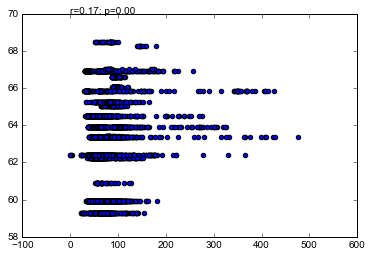

In [13]:
x = np.array(oO3[:].min(), oO3[:].max())
plt.scatter(oO3[:], moO3)
plt.plot(x, lr.slope * x + lr.intercept, ls = '--')
plt.text(x.mean(), plt.ylim()[1], 'r=%.2f; p=%.2f' % (lr.rvalue, lr.pvalue))

# 1 Include More Variables

In [14]:
from scipy.spatial import KDTree
from PseudoNetCDF import PNC
# Read Model Data
margs = PNC('-c', "layer73,valid,0.5,0.5", '--format=bpch,nogroup=("IJ-AVG-$","PEDGE-$"),vertgrid="GEOS-5-NATIVE"', "bpch/ctm.bpch.v10-01-public-Run0.2013050100")
mfile = margs.ifile[0]
mlon = mfile.variables['longitude']
mlat = mfile.variables['latitude']
mpres = mfile.variables['PSURF']
mO3 = mfile.variables['O3']


# Read Observations
oargs = PNC("-f", "ffi1001", "--rename=v,O3_ESRL,O3", "--variables=Fractional_Day,O3_ESRL,LATITUDE,LONGITUDE,PRESSURE", "--expr=latitude=LATITUDE;longitude=np.where(LONGITUDE>180,LONGITUDE-360,LONGITUDE);time=Fractional_Day*24*3600;time.units=\"seconds since 2011-12-31\"", "icartt/dc3-mrg60-dc8_merge_20120518_R7_thru20120622.ict")
ofile = oargs.ifile[0]
olons = ofile.variables['longitude']
olats = ofile.variables['latitude']
opres = ofile.variables['PRESSURE']
oO3 = ofile.variables['O3']

# 2 Nearest Neighbor using pressure/lon/lat as peers

In [15]:
MLON, MLAT = np.meshgrid(mlon, mlat)
MLAT.shape

(46, 72)

In [16]:
MLON = MLON * np.ones_like(mO3[0])
MLAT = MLAT * np.ones_like(mO3[0])
MLAT.shape

(72, 46, 72)

In [17]:
tree = KDTree(np.ma.array([mpres.ravel(), MLAT.ravel(), MLON.ravel()]).T)
dists, idxs = tree.query(np.ma.array([opres, olats, olons]).T)
presidxs, latidxs, lonidxs = np.unravel_index(idxs, MLAT.shape)
moO3 = mO3[:, presidxs, latidxs, lonidxs][0]
moO3.shape

(6817,)

# Plot Paired Results

In [18]:
from scipy.stats.mstats import linregress
lr = linregress(oO3[:], moO3[:])

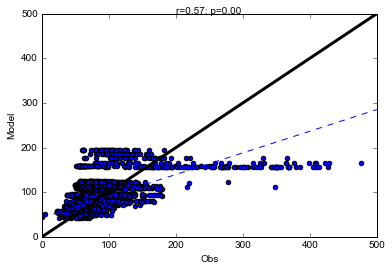

In [19]:
plt.scatter(oO3[:], moO3)
plt.plot([0,500], [0,500], ls = '-', lw = 3, color = 'k')
x = np.array([0, 500])
plt.plot(x, lr.slope * x + lr.intercept, ls = '--')
plt.text(200, 500, 'r=%.2f; p=%.2f' % (lr.rvalue, lr.pvalue))
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.ylabel('Model')
plt.xlabel('Obs');

# Lon/Lat First

In [20]:
MLON, MLAT = np.meshgrid(mlon, mlat)
tree = KDTree(np.ma.array([MLAT.ravel(), MLON.ravel()]).T)
dists, idxs = tree.query(np.ma.array([olats, olons]).T)
latidxs, lonidxs = np.unravel_index(idxs, MLAT.shape)
meO3 = mO3[:, :, latidxs, lonidxs]
meO3.shape

(1, 72, 6817)

In [21]:
dp = opres[None, None,:] - mpres[:, :, latidxs, lonidxs]
pidx = np.abs(dp).argmin(1)[0]
moO3 = meO3[:, pidx, np.arange(pidx.size)][0]
moO3.shape

(6817,)

# Plot the results

In [22]:
from scipy.stats.mstats import linregress
lr = linregress(oO3[:], moO3[:])

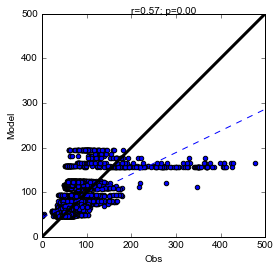

In [23]:
plt.scatter(oO3[:], moO3)
x = np.array([0, 500])
plt.plot(x, x, ls = '-', lw = 3, color = 'k')
plt.axis('square')
plt.xlim(*x)
plt.ylim(*x)
plt.ylabel('Model')
plt.xlabel('Obs')
plt.plot(x, lr.slope * x + lr.intercept, ls = '--')
plt.text(200, 500, 'r=%.2f; p=%.2f' % (lr.rvalue, lr.pvalue));

# Remove Assymetric Variability

- Benchmark has 1 mean-value all months
- DC3 has 1 per minute

In [24]:
idxs = [i for i in zip(pidx, latidxs, lonidxs)]
uniqueset = set(idxs)
idxs = np.array(idxs)
ovals = []
mvals = []
for idx in uniqueset:
    oi = (idxs == idx).all(1)
    ovals.append(oO3[oi].mean())
    mvals.append(mO3[0][idx])
print(len(ovals), len(mvals))

304 304


# Plot Paired Time-Means

In [25]:
from scipy.stats.mstats import linregress
lr = linregress(ovals[:], mvals[:])

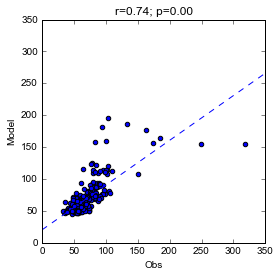

In [26]:
plt.scatter(ovals, mvals)
plt.ylabel('Model')
plt.xlabel('Obs')
plt.axis('square')
plt.xlim(0, 350)
plt.ylim(0, 350)
x = np.array([0, 350])
plt.plot(x, lr.slope * x + lr.intercept, ls = '--')
plt.title('r=%.2f; p=%.2f' % (lr.rvalue, lr.pvalue));

# Interpolation not KDTree

KDTree is just finding a cell

In [1]:
import scipy.interpolate

In [2]:
?scipy.interpolate.NearestNDInterpolator

In [3]:
?scipy.interpolate.LinearNDInterpolator

# Questions

1. Are KDTree and NearestNDInterpolator the same?
2. How different would an analysis be if we had:
    - used LinearNDInterpolator
    - would time normalization be necessary

# Testing Populations

1. Typical with normal assumption
2. Non-parametric tests

# Parametric Tests

- Pearson Correlation (pearsonr)
- Students t-test (ttest_ind)
- Shapiro-Wilk (shapiro)

In [27]:
from scipy.stats.mstats import ttest_ind

In [28]:
ttr = ttest_ind(ovals, mvals)
ttr

Ttest_indResult(statistic=-0.10863433973388822, pvalue=0.91352848251339147)

# Non-Parametric Tests

- Spearman Correlation (spearmanr)
- Mann Whitney U (mannwhitneyu)
- Wilcoxon signed-rank test (wilcoxon)

In [29]:
from scipy.stats.mstats import mannwhitneyu

In [32]:
mwr = mannwhitneyu(ovals, mvals)
mwr

MannwhitneyuResult(statistic=42283.0, pvalue=0.069963935642705352)

# Summary

You should be able to:
1. Spatially interpolate data using scipy.
2. Apply statistical evaluations
  - Parametric (Student's T-test)
  - Non-parametric (Mann-Whitney U)